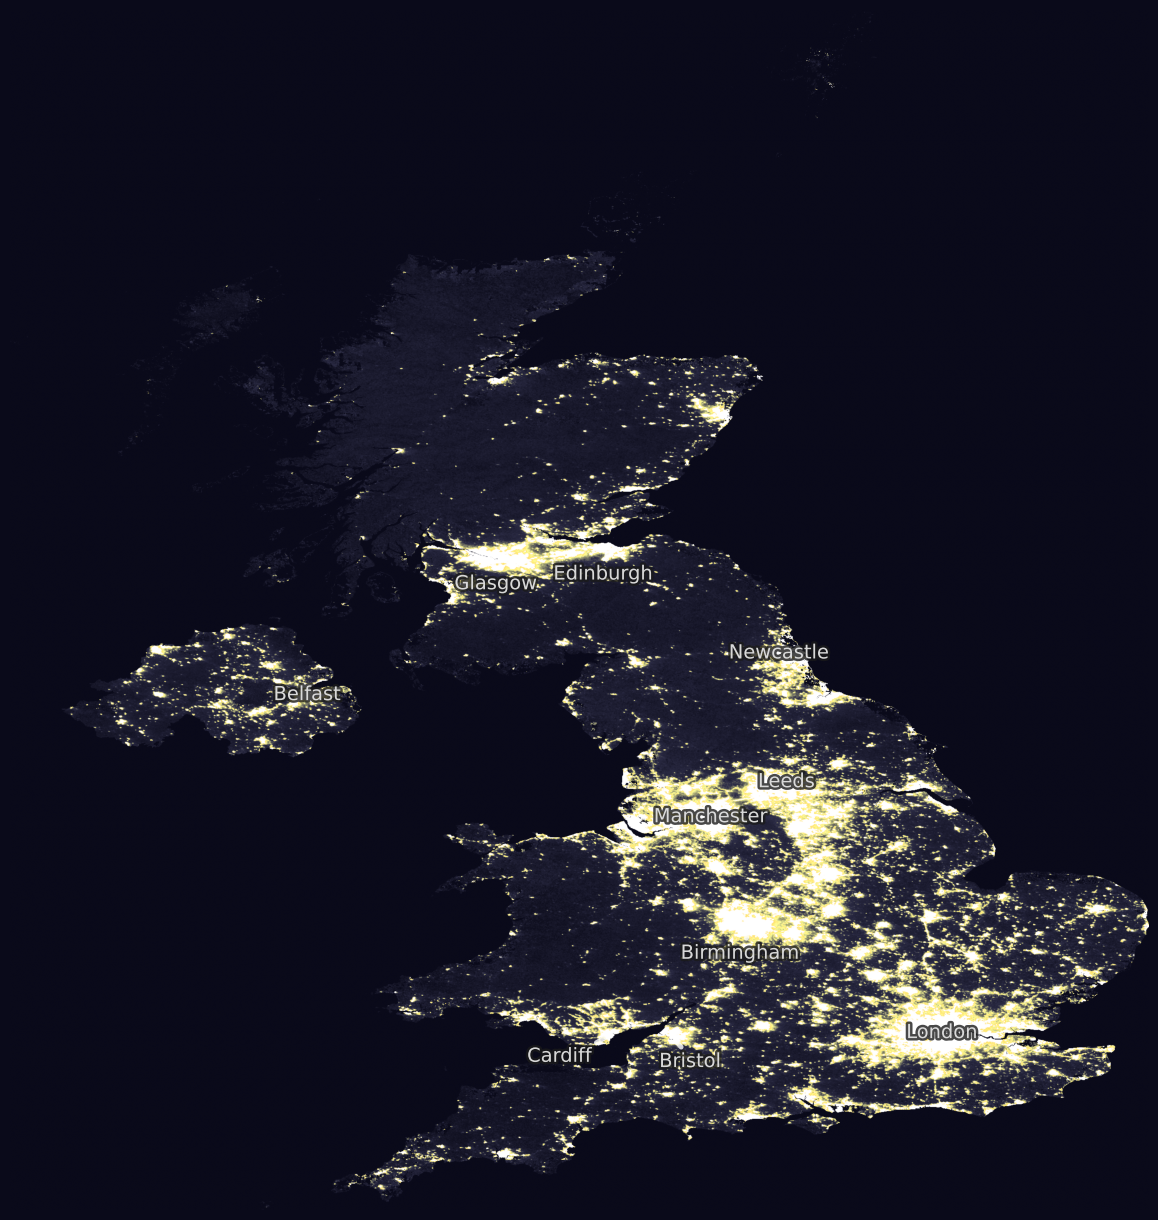

In [5]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe 

# Load the  UK shapefile
shapefile_path = "../Data/Raw/Countries_December_2011_BGC_UK/CTRY_DEC_2024_UK_BGC.shp"
countries = gpd.read_file(shapefile_path)
uk = countries[countries["CTRY24NM"].isin(["England", "Wales", "Scotland", "Northern Ireland"])]
uk = uk.to_crs("EPSG:4326")

# Clip the VIIRS raster to the UK boundary
raster_path = "../Data/Raw/viirs_jan2025.tif"
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, uk.geometry, crop=True)
    out_meta = src.meta.copy()

# Normalise and add contrast
data = out_image[0]
data = np.clip(data, np.percentile(data, 2), np.percentile(data, 98))
data = (data - data.min()) / (data.max() - data.min())
data = np.power(data, 1 / 2.0) 

# Crop to non-zero pixel area
nonzero = np.where(data > 0)
row_min, row_max = nonzero[0].min(), nonzero[0].max()
col_min, col_max = nonzero[1].min(), nonzero[1].max()
cropped = data[row_min:row_max, col_min:col_max]

# Geographic coordinates (longitude, latitude) for major UK cities
cities_lon_lat = {
    "London": (-0.1278, 51.5074),
    "Manchester": (-2.2426, 53.4808),
    "Birmingham": (-1.8904, 52.4862),
    "Leeds": (-1.5492, 53.8008),
    "Glasgow": (-4.2518, 55.8642),
    "Edinburgh": (-3.1883, 55.9533),
    "Belfast": (-5.9301, 54.5973),
    "Cardiff": (-3.1791, 51.4816),
    "Bristol": (-2.5879, 51.4545),     
    "Newcastle": (-1.6178, 54.9783),    
}

city_plot_coords = {}

# Convert lon/lat to pixel coordinates for image
for city, (lon, lat) in cities_lon_lat.items():
    col, row = ~out_transform * (lon, lat)
    plot_x = col - col_min
    plot_y = row - row_min
    if 0 <= plot_x < cropped.shape[1] and 0 <= plot_y < cropped.shape[0]:
        city_plot_coords[city] = (plot_x, plot_y)

# Create colourmap
custom_cmap = LinearSegmentedColormap.from_list(
    "uk_satellite",
    [ "#0A0A1A", "#101020", "#2E2E48", "#FFFF99", "#FFE066", "#FFFFFF" ],
    N=256
)

# Create figure
fig, ax = plt.subplots(figsize=(12, 12), facecolor='#0A0A1A')

ax.imshow(
    cropped,
    cmap=custom_cmap,
    aspect='equal',
    extent=[0, cropped.shape[1], 0, cropped.shape[0]]
)
ax.axis("off")


# Add Labels
city_adjustments = {
    # City: ((x_offset, y_offset), horizontal_align, vertical_align)
    "Birmingham": ((110, -40), 'right', 'top'),
    "Cardiff":    ((-35, -25), 'right', 'top'),
    "Bristol":    ((-30, -30), 'left', 'top'),
    "Edinburgh":    ((100, -40), 'right', 'top'),
    "Glasgow":    ((-80, -40), 'left', 'top'),
}

# Loop through all cities
for city, (x_coord, y_row) in city_plot_coords.items():
    y_coord = cropped.shape[0] - y_row

    if city in city_adjustments:
        (dx, dy), ha, va = city_adjustments[city]
        ax.annotate(
            city,
            xy=(x_coord, y_coord),
            xytext=(x_coord + dx, y_coord + dy),
            textcoords='data',
            ha=ha,
            va=va,
            fontsize=14,
            color='white',
            alpha=0.8,
            weight='normal',
            family='sans-serif',
            path_effects=[pe.withStroke(linewidth=3.5, foreground='#1A1A1A')],
            arrowprops=dict(
                arrowstyle="-",
                connectionstyle="arc3,rad=0.1",
                color='white',
                alpha=0.8,
                linewidth=3.5
            )
        )
    else:
        ax.text(
            x_coord, y_coord, city,
            fontsize=14,
            color='white',
            ha='center',
            va='center',
            alpha=0.8,
            weight='normal',
            family='sans-serif',
            path_effects=[pe.withStroke(linewidth=3.5, foreground='#1A1A1A')]
        )

# Export image
plt.tight_layout(pad=0)
plt.savefig("../Outputs/nightlights_uk_satellite_style_final_v9.png", dpi=400, bbox_inches='tight', facecolor='#0A0A1A')
plt.show()
